In [271]:
# handling file data
import pandas as pd
# handling numerical data
import numpy as np
# for ploting/visualisation
import matplotlib.pyplot as plt
import seaborn as sns 

# importing Natural Language Toolkit
import nltk

# data pre-processing
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# split into train and test
from sklearn.model_selection import train_test_split
# transform data
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# feature reduction/
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
# model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
# model accuracy report
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

In [272]:
train = pd.read_csv("/Users/ankitbaliyan/Documents/VS_Code/Ongoing projects/NLP_Disaster/dataset/train.csv")
test = pd.read_csv("/Users/ankitbaliyan/Documents/VS_Code/Ongoing projects/NLP_Disaster/dataset/test.csv")
submission = pd.read_csv("//Users/ankitbaliyan/Documents/VS_Code/Ongoing projects/NLP_Disaster/dataset/sample_sub.csv")

# merging train and test datasets 
data=pd.concat([train, test], axis=0)
data.shape

(10876, 5)

# Check Descriptive Statistics

In [273]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0


In [274]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10876 entries, 0 to 3262
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        10876 non-null  int64  
 1   keyword   10789 non-null  object 
 2   location  7238 non-null   object 
 3   text      10876 non-null  object 
 4   target    7613 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 509.8+ KB


In [275]:
data[data.isna()].sum()

id          0.0
keyword       0
location      0
text          0
target      0.0
dtype: object

0.0    4342
1.0    3271
Name: target, dtype: int64


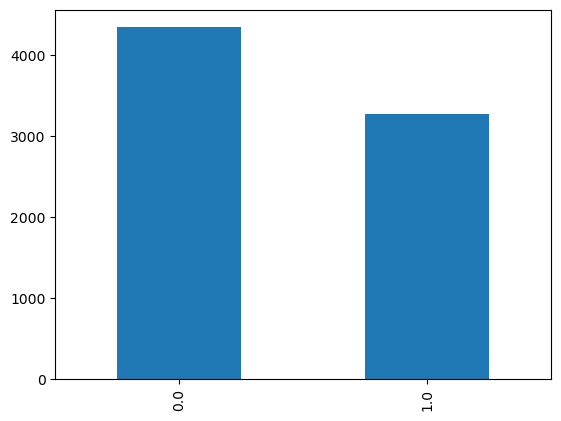

In [276]:
print(data['target'].value_counts())
data['target'].value_counts().plot(kind='bar')
plt.show()

In [277]:
# calculating the length of each document
data['length'] = data['text'].apply(lambda x: len(x))
print("Mean length of text when Disaster:",data[data['target']==1].length.mean())
print("Mean length of text when No Disaster:",data[data['target']==0].length.mean())

# Observation: longer tweet when actual disaster

Mean length of text when Disaster: 108.11342097217977
Mean length of text when No Disaster: 95.70681713496084


In [278]:
# #_word vs disaster

# filter out the words that starts with #
data["#word"] = data['text'].apply(lambda x: list(word for word in x.split() if word[0]=='#'))

# count # words in the text column
data['number_of_#words']=data['#word'].apply(lambda x: len(x))

# check averange numbr of #words in tweet with disaster and not disaster
print("Average number of #words in tweeets from Disaster",data[(data['target']==1) & (data['number_of_#words']!=0)]['number_of_#words'].mean())
print("Average number of #words in tweeets from No Disaster",data[(data['target']==0) & (data['number_of_#words']!=0)]['number_of_#words'].mean())

# Observation: Not much of relation between number of # words used vs disaster

Average number of #words in tweeets from Disaster 1.9428238039673278
Average number of #words in tweeets from No Disaster 1.9099201824401368


In [279]:
data.head()

,id,keyword,location,text,target,length,#word,number_of_#words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,69,[#earthquake],1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,38,[],0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,133,[],0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,65,[#wildfires],1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,88,"[#Alaska, #wildfires]",2


# since no relation, removing #word and number_of_#words
for col in ['#word', 'number_of_#words']:
    if col in data.columns:
        data.drop(col, axis=1, inplace=True)

In [280]:
data.head()

,id,keyword,location,text,target,length,#word,number_of_#words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,69,[#earthquake],1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,38,[],0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,133,[],0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,65,[#wildfires],1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,88,"[#Alaska, #wildfires]",2


# Perform Punctuation Removal and Convert to Lower Case

In [281]:
# lower case
data['text']=data['text'].apply(lambda x: x.lower())

In [282]:
# special character removeal
def remove_special_characters(text):
    # Define a list of special characters to remove
    special_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"

    # Remove special characters using str.translate() method
    cleaned_text = text.translate(str.maketrans('', '', special_chars))
    return cleaned_text

data['processed_text']=data['text'].apply(lambda x: remove_special_characters(x))

data.head()

,id,keyword,location,text,target,length,#word,number_of_#words,processed_text
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1.0,69,[#earthquake],1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,forest fire near la ronge sask. canada,1.0,38,[],0,forest fire near la ronge sask canada
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1.0,133,[],0,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,65,[#wildfires],1,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1.0,88,"[#Alaska, #wildfires]",2,just got sent this photo from ruby alaska as s...


# 	Remove Stop Words

In [283]:
# removing stopwords
stop= stopwords.words('english')

data['processed_text'] = data['processed_text'].apply(lambda x: " ".join([word for word in x.split() if word not in stop]))

data.head()

,id,keyword,location,text,target,length,#word,number_of_#words,processed_text
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1.0,69,[#earthquake],1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,forest fire near la ronge sask. canada,1.0,38,[],0,forest fire near la ronge sask canada
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1.0,133,[],0,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,65,[#wildfires],1,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1.0,88,"[#Alaska, #wildfires]",2,got sent photo ruby alaska smoke wildfires pou...


In [284]:
# stemming
from nltk.stem import PorterStemmer
stem = PorterStemmer()
data['processed_text'].apply(lambda x: " ".join([stem.stem(word) for word in x.split()]))

# lemmatization
lem = WordNetLemmatizer()
data['processed_text'] = data['processed_text'].apply(lambda x: " ".join([lem.lemmatize(word) for word in x.split()]))


data.head()

,id,keyword,location,text,target,length,#word,number_of_#words,processed_text
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1.0,69,[#earthquake],1,deed reason earthquake may allah forgive u
1,4,NaN,NaN,forest fire near la ronge sask. canada,1.0,38,[],0,forest fire near la ronge sask canada
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1.0,133,[],0,resident asked shelter place notified officer ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,65,[#wildfires],1,13000 people receive wildfire evacuation order...
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1.0,88,"[#Alaska, #wildfires]",2,got sent photo ruby alaska smoke wildfire pour...


In [285]:
# Removing URLs from the text
def remove_urls(text):
    pattern = r'http\S+'  # Regex pattern to match URLs
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

data['processed_text']=data['processed_text'].apply(remove_urls)

# Code to perform train & test split

In [286]:
# split to original test and train

i = train.shape[0]
train = data[:i]
test = data[i:]

# x,y as the independent and dependent variable 
x=train[['processed_text','length']]
y=train['target']
test = test[['processed_text','length']]


# spliting train and test data
x_train,  x_val, y_train, y_val = train_test_split(x,y, test_size=0.2, random_state=42)

# Transform to TF-IDF

In [287]:
# feature extraction 

def feature_extraction(fe):
    print("Feature Extraction using:",fe)
    # transforming data
    fe.fit(x_train['processed_text'])

    x_train_fe = fe.transform(x_train['processed_text']).toarray()
    x_val_fe = fe.transform(x_val['processed_text']).toarray()
    test_fe = fe.transform(test['processed_text']).toarray()
    
    return(x_train_fe, x_val_fe, test_fe)


max_feature = 3000
cv = CountVectorizer(max_features=max_feature)
tfidf = TfidfVectorizer(max_features=max_feature)

x_train_fe, x_val_fe, test_fe = feature_extraction(tfidf)

Feature Extraction using: TfidfVectorizer(max_features=3000)


# Perform PCA (if required)

In [288]:
def reduce_dimension(technique):
    print("Feature Reduction:", technique)
    technique.fit(x_train_fe)
    
    x_train_fe_r = technique.transform(x_train_fe)
    x_val_fe_r = technique.transform(x_val_fe)

    test_fe_r = technique.transform(test_fe)

    return( x_train_fe_r, x_val_fe_r, test_fe_r)



n=7
svd = TruncatedSVD(n_components=n)  # Specify the number of components to keep
pca = PCA(n_components=n)

x_train_fe_r, x_val_fe_r, test_fe_r = reduce_dimension(pca)


Feature Reduction: PCA(n_components=7)


# 	Write a code to build Logistic Regression Model

In [289]:
from sklearn.linear_model import LogisticRegression

# creating instance
lr = LogisticRegression()
# training model
lr.fit(x_train_fe, y_train)
# predicting for training data and validation set
lr_pred_train = lr.predict(x_train_fe)
lr_pred = lr.predict(x_val_fe)

# report:
print(f"classification_report:(Train - {lr})")
print(classification_report(lr_pred_train,y_train))
print(f"\n Classification Report: (Validation - {lr})")
print(classification_report(lr_pred, y_val))

classification_report:(Train - LogisticRegression())
              precision    recall  f1-score   support

         0.0       0.94      0.84      0.89      3872
         1.0       0.77      0.91      0.83      2218

    accuracy                           0.87      6090
   macro avg       0.86      0.88      0.86      6090
weighted avg       0.88      0.87      0.87      6090


 Classification Report: (Validation - LogisticRegression())
              precision    recall  f1-score   support

         0.0       0.88      0.80      0.84       961
         1.0       0.70      0.81      0.75       562

    accuracy                           0.80      1523
   macro avg       0.79      0.80      0.79      1523
weighted avg       0.81      0.80      0.80      1523



# Write a code to build Decision Tree Model

In [290]:
from sklearn.tree import DecisionTreeClassifier

# creating instance
dtc = DecisionTreeClassifier()
# training model
dtc.fit(x_train_fe, y_train)
# predicting for training data and validation set
dtc_pred_train = dtc.predict(x_train_fe)
dtc_pred = dtc.predict(x_val_fe)

# report:
print("classification_report:(Train)")
print(classification_report(dtc_pred_train,y_train))
print("\n Classification Report: (Validation)")
print(classification_report(dtc_pred, y_val))

classification_report:(Train)
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      3545
         1.0       0.97      1.00      0.98      2545

    accuracy                           0.98      6090
   macro avg       0.98      0.99      0.98      6090
weighted avg       0.98      0.98      0.98      6090


 Classification Report: (Validation)
              precision    recall  f1-score   support

         0.0       0.73      0.75      0.74       858
         1.0       0.67      0.65      0.66       665

    accuracy                           0.71      1523
   macro avg       0.70      0.70      0.70      1523
weighted avg       0.71      0.71      0.71      1523



# Write a code to build Random Forest Model

In [291]:
from sklearn.ensemble import RandomForestClassifier

# creating instance
rfc = RandomForestClassifier(n_estimators=500, random_state=42)
# training model
rfc.fit(x_train_fe, y_train)
# predicting for training data and validation set
rfc_pred_train = rfc.predict(x_train_fe)
rfc_pred = rfc.predict(x_val_fe)

# report:
print("classification_report:(Train)")
print(classification_report(rfc_pred_train,y_train))
print("\n Classification Report: (Validation)")
print(classification_report(rfc_pred, y_val))

classification_report:(Train)
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      3521
         1.0       0.97      0.99      0.98      2569

    accuracy                           0.98      6090
   macro avg       0.98      0.99      0.98      6090
weighted avg       0.98      0.98      0.98      6090


 Classification Report: (Validation)
              precision    recall  f1-score   support

         0.0       0.82      0.79      0.81       910
         1.0       0.71      0.75      0.73       613

    accuracy                           0.78      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



# Choose the best model and build model again

In [292]:
from sklearn import svm

# creating instance
svm = svm.SVC()
# training model
svm.fit(x_train_fe, y_train)
# predicting for training data and validation set
svm_pred_train = svm.predict(x_train_fe)
svm_pred = svm.predict(x_val_fe)

# report:
print("classification_report:(Train)")
print(classification_report(svm_pred_train,y_train))
print("\n Classification Report: (Validation)")
print(classification_report(svm_pred, y_val))

classification_report:(Train)
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96      3681
         1.0       0.90      0.98      0.94      2409

    accuracy                           0.95      6090
   macro avg       0.94      0.95      0.95      6090
weighted avg       0.95      0.95      0.95      6090


 Classification Report: (Validation)
              precision    recall  f1-score   support

         0.0       0.89      0.79      0.84       980
         1.0       0.69      0.82      0.75       543

    accuracy                           0.80      1523
   macro avg       0.79      0.81      0.79      1523
weighted avg       0.82      0.80      0.80      1523



In [293]:

# creating instance
mnb = MultinomialNB()
# training model
mnb.fit(x_train_fe, y_train)
# predicting for training data and validation set
mnb_pred_train = mnb.predict(x_train_fe)
mnb_pred = mnb.predict(x_val_fe)

# report:
print("classification_report:(Train)")
print(classification_report(mnb_pred_train,y_train))
print("\n Classification Report: (Validation)")
print(classification_report(mnb_pred, y_val))

classification_report:(Train)
              precision    recall  f1-score   support

         0.0       0.93      0.83      0.88      3904
         1.0       0.75      0.90      0.81      2186

    accuracy                           0.85      6090
   macro avg       0.84      0.86      0.85      6090
weighted avg       0.87      0.85      0.86      6090


 Classification Report: (Validation)
              precision    recall  f1-score   support

         0.0       0.87      0.79      0.83       972
         1.0       0.68      0.80      0.73       551

    accuracy                           0.79      1523
   macro avg       0.78      0.79      0.78      1523
weighted avg       0.80      0.79      0.79      1523



In [294]:
def build_model(model, 
                x_train= x_train_fe,
                x_val=x_val_fe,
                x_test=test_fe):
    print("Model used:",model)
    # training model
    model.fit(x_train, y_train)
    # predicting for training data and validation set
    model_pred_train = model.predict(x_train)
    model_pred = model.predict(x_val)
    test_pred = model.predict(x_test)

    # report:
    print("classification_report:(Train)")
    print(classification_report(model_pred_train,y_train))
    print("Accuracy Score:Training",accuracy_score(model_pred_train,y_train))
    print("\n Classification Report: (Validation)")
    print(classification_report(model_pred, y_val))
    print("Accuracy Score:",accuracy_score(model_pred, y_val))

    return (test_pred)

# model train and prediction
instance_lr = LogisticRegression()
instance_dtc = DecisionTreeClassifier()
instance_rfc = RandomForestClassifier(n_estimators=500, random_state=42)
#instance_svm = svm.SVC()
instance_mnb = MultinomialNB()



In [295]:
# Features extraction
maxf = 3000
cv = CountVectorizer(max_features=maxf)
tfidf = TfidfVectorizer(max_features=maxf)
x_train_fe, x_val_fe, test_fe = feature_extraction(tfidf)


# features reduction
n=7
svd = TruncatedSVD(n_components=n)  # Specify the number of components to keep
pca = PCA(n_components=n)
x_train_fe_r, x_val_fe_r, test_fe_r = reduce_dimension(pca)


print("Building model without frature reduction:")
sub_test_pred = build_model(instance_lr, 
                        x_train= x_train_fe, 
                        x_val=x_val_fe, 
                        x_test=test_fe)

print("\nBuilding model after reducing features:")
test_pred = build_model(instance_lr, 
                        x_train= x_train_fe_r, 
                        x_val=x_val_fe_r, 
                        x_test=test_fe_r)


# F1 score is lower if dimensionality reduced.

Feature Extraction using: TfidfVectorizer(max_features=3000)
Feature Reduction: PCA(n_components=7)
Building model without frature reduction:
Model used: LogisticRegression()
classification_report:(Train)
              precision    recall  f1-score   support

         0.0       0.94      0.84      0.89      3872
         1.0       0.77      0.91      0.83      2218

    accuracy                           0.87      6090
   macro avg       0.86      0.88      0.86      6090
weighted avg       0.88      0.87      0.87      6090

Accuracy Score:Training 0.8679802955665025

 Classification Report: (Validation)
              precision    recall  f1-score   support

         0.0       0.88      0.80      0.84       961
         1.0       0.70      0.81      0.75       562

    accuracy                           0.80      1523
   macro avg       0.79      0.80      0.79      1523
weighted avg       0.81      0.80      0.80      1523

Accuracy Score: 0.8023637557452397

Building model after red

In [ ]:
data.head()

In [296]:
# split test and train

i = train.shape[0]
train = data[:i]
test = data[i:]

from sklearn.metrics import accuracy_score

# Split the data into features (text and length) and target
X = train[['processed_text', 'length','number_of_#words']]
y = train['target']
test = test[['processed_text','length','number_of_#words']]

# Convert text to numerical representation using TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=3000)
vectorizer.fit(X['processed_text'])
X_text = vectorizer.transform(X['processed_text'])
test_text = vectorizer.transform(test['processed_text'])

# Combine text and length features
X_combined = pd.concat([pd.DataFrame(X_text.toarray()), X[['length','number_of_#words']]], axis=1)
test_combined = pd.concat([pd.DataFrame(test_text.toarray()), test[['length','number_of_#words']]], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Build and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
submission['target']=model.predict(test_combined)

# Calculate and print the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


print(classification_report(y_test, y_pred))

/Users/ankitbaliyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/ankitbaliyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ankitbaliyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 

Accuracy: 0.8069599474720945
              precision    recall  f1-score   support

         0.0       0.80      0.89      0.84       874
         1.0       0.82      0.70      0.76       649

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



In [297]:
submission['target'] = submission['target'].apply(lambda x: round(x))
#submission.to_csv("/Users/ankitbaliyan/Documents/VS_Code/Ongoing projects/NLP_Disaster/subission file/submission_9.csv", index=False)
print(submission.target.value_counts())
submission.head()

0    2085
1    1178
Name: target, dtype: int64


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
